# 9.7.4 Renewable Resource Management

From Miranda and Fackler, Applied Computational Economics and Finance, 2002, Section 9.7.4

資源ストック（米のようなもの？）$s$のうち$x$を収穫し、それを売却し利益を得る。  
収穫コストは$c(x)$、価格は$p(x)$。  
$t+1$期のsは$s_{t+1}=h(s_{t}-x_{t})$

state variable $s\in[0,s)$  
action variable $x\in[0,s]$  
state transaction function $g(s,x)=h(s-x)$  
reward function $f(s,x)=\int_0^x p(\xi) d\xi-c(x)$  
Bellman equation $V(s)=max_{0\leq x\leq s} \{\int_0^x p(\xi) d\xi-c(x)+\delta V(h(s-x))\} $

今回の例では  
$g(s,x)=\alpha(s-x)-0.5\beta(s-x)^2$  
$p(x)=x^{-\gamma}$  
$f(s,x) =  \int_0^x p(\xi) d\xi-c(x) =\cfrac{x^{1-\gamma}}{1-\gamma} -\kappa x$

In [1]:
using QuantEcon
using BasisMatrices
using Plots
using Optim

In [2]:
struct RenewableResourceManagement
    alpha::Float64
    beta::Float64
    gamma::Float64
    kappa::Float64
    delta::Float64
    s_vec::Vector{Float64}
end

In [3]:
n = 1000
smin = 0
smax = 10
fspace = Basis(ChebParams(n,smin,smax))
snodes = nodes(fspace)

([6.1685e-6, 5.55164e-5, 0.000154212, 0.000302254, 0.00049964, 0.00074637, 0.00104244, 0.00138785, 0.00178259, 0.00222666  …  9.99777, 9.99822, 9.99861, 9.99896, 9.99925, 9.9995, 9.9997, 9.99985, 9.99994, 9.99999], Array{Float64,1}[[6.1685e-6, 5.55164e-5, 0.000154212, 0.000302254, 0.00049964, 0.00074637, 0.00104244, 0.00138785, 0.00178259, 0.00222666  …  9.99777, 9.99822, 9.99861, 9.99896, 9.99925, 9.9995, 9.9997, 9.99985, 9.99994, 9.99999]])

In [4]:
RRM = RenewableResourceManagement(4.0,1.0,0.5,0.2,0.9,snodes[1])

RenewableResourceManagement(4.0, 1.0, 0.5, 0.2, 0.9, [6.1685e-6, 5.55164e-5, 0.000154212, 0.000302254, 0.00049964, 0.00074637, 0.00104244, 0.00138785, 0.00178259, 0.00222666  …  9.99777, 9.99822, 9.99861, 9.99896, 9.99925, 9.9995, 9.9997, 9.99985, 9.99994, 9.99999])

In [5]:
function update_bellman!(RRM::RenewableResourceManagement,V::Vector)
    a,b,g,k,d = RRM.alpha, RRM.beta, RRM.gamma, RRM.kappa, RRM.delta
    V_func = LinInterp(RRM.s_vec, V)
    V_new = similar(V)
    policy = similar(V)
    
    for (i, s) in enumerate(RRM.s_vec)
        objective(x) =  -((x^(1-g))/(1-g) -k*x +d*(V_func.(a*(s-x)-0.5*b*(s-x)^2)))
        opt = optimize(objective,1e-10,s)
        V_new[i] = -opt.minimum
        policy[i] = opt.minimizer
    end
    return V_new,policy
end

update_bellman! (generic function with 1 method)

In [6]:
V = Vector{Float64}(length(RRM.s_vec))
for i in 1:length(RRM.s_vec)
    V[i] = 6
end

In [7]:
V_comp = similar(V)
policy = similar(V)
tol = sqrt(eps())
max_iter = 1000
V_error = 1.0
i = 1
while V_error > tol && i <= max_iter
    V_comp ,policy = update_bellman!(RRM,V)
    V_error = maximum(abs, V_comp - V) 
    copy!(V,V_comp)
    i += 1
end

In [8]:
policy

1000-element Array{Float64,1}:
 1.0e-10   
 2.63784e-9
 1.79843e-8
 6.28802e-8
 1.59767e-7
 3.36229e-7
 6.23869e-7
 1.06019e-6
 1.68404e-6
 2.54262e-6
 3.68439e-6
 5.15858e-6
 7.02374e-6
 ⋮         
 6.78719   
 6.78767   
 6.78811   
 6.78851   
 6.78886   
 6.78917   
 6.78943   
 6.78965   
 6.78983   
 6.78996   
 6.79005   
 6.79009   

In [9]:
V

1000-element Array{Float64,1}:
 10.654 
 13.8107
 14.9782
 15.7789
 16.3996
 16.9106
 17.3473
 17.73  
 18.0713
 18.3799
 18.6619
 18.9219
 19.1634
  ⋮     
 33.9944
 33.9945
 33.9946
 33.9947
 33.9948
 33.9948
 33.9949
 33.9949
 33.995 
 33.995 
 33.995 
 33.995 


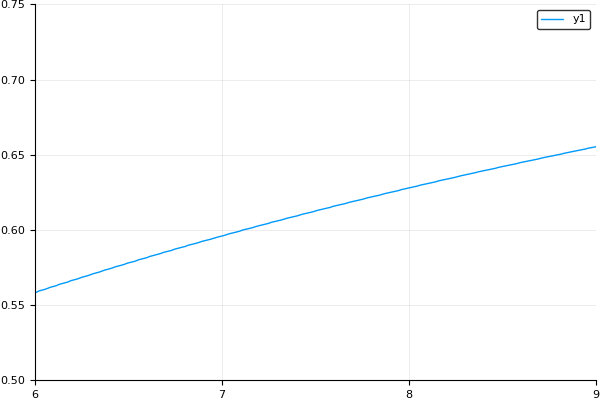

In [10]:
plot(RRM.s_vec,policy./RRM.s_vec,xlim = (6,9),ylim=(0.5,0.75))


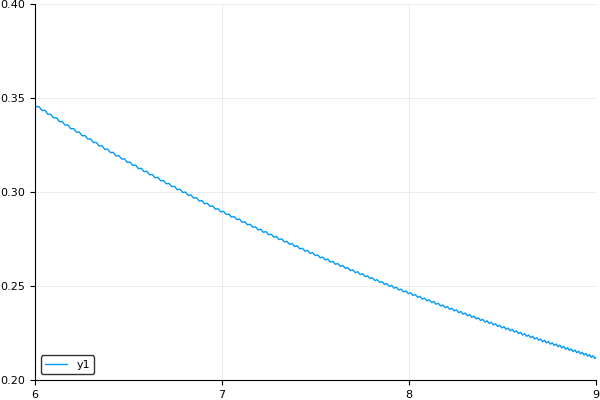

In [11]:
Phi = BasisMatrix(fspace, Expanded(), RRM.s_vec, 0)
coef = Phi.vals[1] \ V
order = 1
B1 = evalbase(fspace.params[1], RRM.s_vec, order)
interp1 = B1 * coef
plot(RRM.s_vec, interp1, xlim = (6,9),ylim=(0.2,0.4))

LQモデルに当てはめる（？）

LQ  
stete vectorを$s$、control vectorを$x$、（今回は無いが）shockを$w$として、state transitionを  
\begin{eqnarray*}
s_{t+1}=As_t+Bx_t+Cw_{t+1} \\
\end{eqnarray*}
とし、目的関数  
\begin{eqnarray*}
r(s,x):=s^T_tRs_t+x^T_tQx_t+2x^T_tNs_t \\
\end{eqnarray*}
を最小化する。  

今回の例では、$r(s,x)を-f(s,x)$とし、これを最小化させる

$f(s,x)をs^*、x^*$の周りで2次までで展開すると、  
\begin{eqnarray*}
f(s,x) \simeq f(s^*,x^*)+f_s(s^*,x^*)(s-s^*)+f_x(s^*,x^*)(x-x^*)+\cfrac{1}{2}f_{ss}(s^*,x^*)(s-s^*)^2+\cfrac{1}{2}f_{xx}(s^*,x^*)(x-x^*)^2+f_{sx}(s^*,x^*)(s-s^*)(x-x^*) \\
\end{eqnarray*}

$g(s,x)をs^*、x^*$の周りで1次までで展開すると、  
\begin{eqnarray*}
g(s,x) \simeq g(s^*,x^*)+g_s(s^*,x^*)(s-s^*)+g_x(s^*,x^*)(x-x^*) \\
\end{eqnarray*}

stateを$s'=s-s^*$、actionを$x'=x-x^*$とする。
\begin{eqnarray*}
f(s,x) \simeq f^*+f_s^*s'+f_x^*x'+\cfrac{1}{2}f_{ss}^*s'^2+\cfrac{1}{2}f_{xx}^*x'^2+f_{sx}^*s'x' \\
\end{eqnarray*}  
\begin{eqnarray*}
=\begin{pmatrix} s' & 1 \end{pmatrix}\begin{pmatrix} \cfrac{1}{2}f^*_{ss} & \cfrac{1}{2}f^*_{s} \\  \cfrac{1}{2}f^*_{s} & f^* \end{pmatrix}\begin{pmatrix} s' \\ 1 \end{pmatrix}+\cfrac{1}{2}f^*_{xx}x'^2+2x'\begin{pmatrix} \cfrac{1}{2}f^*_{sx} & \cfrac{1}{2}f^*_x \end{pmatrix}\begin{pmatrix} s' \\ 1 \end{pmatrix}
\end{eqnarray*}  
よって
\begin{eqnarray*}
R=\begin{pmatrix} \cfrac{1}{2}f^*_{ss} & \cfrac{1}{2}f^*_{s} \\  \cfrac{1}{2}f^*_{s} & f^* \end{pmatrix}, & Q=\cfrac{1}{2}f^*_{xx}, & N=\begin{pmatrix} \cfrac{1}{2}f^*_{sx} & \cfrac{1}{2}f^*_x \end{pmatrix}
\end{eqnarray*}
また、state transiotionは
\begin{eqnarray}
g(s,x) \simeq g^*+g_s^*s'+g_x^*x' 
\end{eqnarray}
\begin{eqnarray}
\Leftrightarrow \begin{pmatrix} s'_{t+1} \\ 1 \end{pmatrix}=\begin{pmatrix} g^*_s & g^* \\  0 & 1 \end{pmatrix}\begin{pmatrix} s'_t \\ 1 \end{pmatrix}+\begin{pmatrix} g^*_x \\ 0 \end{pmatrix}x'_t
\end{eqnarray}
よって、
\begin{eqnarray*}
A=\begin{pmatrix} g^*_s & g^* \\  0 & 1 \end{pmatrix}, & B=\begin{pmatrix} g^*_x \\ 0 \end{pmatrix}
\end{eqnarray*}

$y=s-x$とし、$f(s,x) =\cfrac{x^{1-\gamma}}{1-\gamma} -\kappa x=\cfrac{(s-y)^{1-\gamma}}{1-\gamma} -\kappa (s-y)$とする。  
  
$f_{s}=(s-y)^{-\gamma}-\kappa$  
$f_{y}=-(s-y)^{-\gamma}+\kappa$  
$f_{ss}=f_{yy}=f_{sy}=-\gamma(s-y)^{-\gamma-1}$  
  
$g(s,x)=\alpha(s-x)-0.5\beta(s-x)^2=\alpha y-0.5\beta y^2$  
$g_{s}=0$  
$g_{y}=\alpha-\beta y$

よって、今回の例では  
$R=\begin{pmatrix} -\cfrac{1}{2}f^*_{ss} & -\cfrac{1}{2}f^*_{s} \\  -\cfrac{1}{2}f^*_{s} & -f^* \end{pmatrix}$  
$Q=-\cfrac{1}{2}f^*_{xx}$  
$N=\begin{pmatrix} -\cfrac{1}{2}f^*_{sx} & -\cfrac{1}{2}f^*_x \end{pmatrix}$  
$A=\begin{pmatrix} 0 & g^* \\  0 & 1 \end{pmatrix}$    $B=\begin{pmatrix} g^*_x \\ 0 \end{pmatrix}$  

In [12]:
a,b,r,k,d = RRM.alpha, RRM.beta, RRM.gamma, RRM.kappa, RRM.delta
sstar = (a^2 - 1/(d^2))/(2*b)
xstar = sstar - (d*a - 1)/(d*b)
ystar = sstar - xstar
f(s,y) = ((s-y)^(1-r))/(1-r) -k*(s-y)
fs(s,y) = (s-y)^(-r) -k
fy(s,y) = -(s-y)^(-r) +k
fss(s,y) = -r*(s-y)^(-1-r)
g(y) = a*y - 0.5*b*y^2
gy(y) = a - b*y
 
Q = -0.5*fss(sstar,ystar)
R = [-0.5*fss(sstar,ystar) -0.5*fs(sstar,ystar)
        -0.5*fs(sstar,ystar) -f(sstar,ystar)]
N = [-0.5*fss(sstar,ystar) -0.5*fy(sstar,ystar)]
A = [0 g(ystar)
        0.0 1.0]
B = [gy(ystar); 0]
C = [0;0]
lq = LQ(Q,R,A,B,C,N;bet=d)

QuantEcon.LQ(0.0262431197105178, [0.0262431 -0.135864; -0.135864 -3.34096], [0.0 7.38272; 0.0 1.0], [1.11111, 0.0], [0, 0], [0.0262431 0.135864], 0.9, nothing, [NaN NaN; NaN NaN], [NaN NaN; NaN NaN], 0.0, [0.0 0.0])

In [13]:
P,F,d = stationary_values(lq)

([0.00262431 -0.145042; -0.145042 -51.4324], [0.9 0.349708], 0.0)

In [14]:
s0 = [6.0-sstar;1.0]
sp, up = compute_sequence(lq,s0)
stock=sp[1,:]+sstar

101-element Array{Float64,1}:
  6.0   
 15.7596
  6.0   
 15.7596
  6.0   
 15.7596
  6.0   
 15.7596
  6.0   
 15.7596
  6.0   
 15.7596
  6.0   
  ⋮     
 15.7596
  6.0   
 15.7596
  6.0   
 15.7596
  6.0   
 15.7596
  6.0   
 15.7596
  6.0   
 15.7596
  6.0   

In [15]:
up

1×100 Array{Float64,2}:
 0.894737  -7.88889  0.894737  -7.88889  …  -7.88889  0.894737  -7.88889